In [ ]:
%reset

In [1]:
import pandas as pd
import hashlib
from rdkit import Chem
from rdkit.Chem import AllChem
import pybel

In [2]:
df = pd.read_csv('chebi_and_metacyc_molecules.csv', dtype=str)

In [ ]:
s1 = lambda i: '{} {} {}'.format(df.loc[i, 'name'], 
                                 df.loc[i, 'sanitized_smiles'],
                                 df.loc[i, 'formula'])

s2 = lambda i: '{} {}'.format(df.loc[i, 'name'], df.loc[i, 'formula'])
s3 = lambda i: '{} {}'.format(df.loc[i, 'name'], df.loc[i, 'sanitized_smiles'])
s4 = lambda i: '{} {}'.format(df.loc[i, 'formula'], df.loc[i, 'sanitized_smiles'])

potato = lambda s: [hashlib.sha256(s(i)).hexdigest() for i in range(len(df))]
name_form_smile = potato(s1)
name_form = potato(s2)
name_smile = potato(s3)
form_smile = potato(s4)

df['name_form_smile'] = name_form_smile
df['name_form'] = name_form
df['name_smile'] = name_smile
df['form_smile'] = form_smile

In [3]:
# %load metatlas.py
"""
FireWorks implementation for the computation of electronic structure for
molecules in the Metatlas database.

-----------    ----------    -----------
| Create  |    | Run    |    | Process |
| Orca    | => | Orca   | => | Output  |
| Input   |    | Calc   |    | File    |
-----------    ----------    -----------
"""
import re
import subprocess
import pybel
from mendeleev import element
from fireworks import Firework, FiretaskBase, FWAction
import psi4

class ComputeEnergyTask(FiretaskBase):
    _fw_name = 'ComputeEnergyTask'
    required_params = ['input_string', 'calc_details']

    def _write_string_to_orca_file(self, formula, input_string):
        input_name = formula + '.inp'
        with open(input_name, 'w') as f:
            f.write(input_string)

        return

    def _calculate_energy(self):
        formula = self['calc_details']['molecular_formula']
        fname = formula + '.inp'
        path_to_output = formula + '.out'
        with open(path_to_output, 'w') as f:
            p = subprocess.Popen(['srun', 'orca', formula+'.inp'], stdout=f)
            p.wait()

        return path_to_output

    def run_task(self, fw_spec):
        formula = self['calc_details']['molecular_formula']
        input_string = self['input_string']
        self._write_string_to_orca_file(formula, input_string)

        try:
            with open(formula+'.out', 'r') as f:
                content = f.read()
        except IOError:
            print 'No output file found yet. Running!'
            try:
                path_to_output = self._calculate_energy()
                with open(path_to_output, 'r') as f:
                    contents = f.read()

                if 'TERMINATED NORMALLY' not in contents:
                    raise
            except:  # some kind of fault error
                rerun_fw = Firework(ComputeEnergyTask(input_string=self['input_string'],
                                                      calc_details=self['calc_details']),
                                    name=formula)
                return FWAction(detours=rerun_fw)
        else:
            if 'OPTIMIZATION RUN DONE' not in content:
                print 'Not optimized. Running!'
                try:
                    path_to_output = self._calculate_energy()
                    with open(path_to_output, 'r') as f:
                        contents = f.read()

                    if 'TERMINATED NORMALLY' not in contents:
                        raise
                except:  # some kind of fault error
                    rerun_fw = Firework(ComputeEnergyTask(input_string=self['input_string'],
                                                          calc_details=self['calc_details']),
                                        name=formula)
                    return FWAction(detours=rerun_fw)

        Results = ParseResults(formula+'.trj')

        return FWAction(
            stored_data={
                'energy': {
                    'value': Results.energy,
                    'units': 'Hartree'
                },
                'optimized_coords': Results.opt_coords
            })



class ParseResults(object):
    def __init__(self, path_to_calc_file):
        with open(path_to_calc_file, 'r') as output:
            content = output.readlines()

        natoms = int(content[0].strip())
        # back up 2 additional items, energy, natoms in xyz format
        content = content[-natoms-2:]

        self.opt_coords = ''.join(content)
        self.energy = self._get_energy(content[1])

    def _get_energy(self, contents):
        match = re.search(r'\-[0-9]+\.[0-9]+', contents)
        return match.group(0)


class AddCalculationtoDBTask(FiretaskBase):
    required_params = ['path_to_calc_output']
    def run_task(self, fw_spec):
        path_to_calc_output = ' '
        return FWAction()


class ProtonateMolecule(ComputeEnergyTask):

    def protonate(m, atom, db):
        mm = ob.OBMol(m)
        atom.IncrementImplicitValence()
        mm.AddHydrogens(atom)
        print 'protonating atom', mm.GetFormula()
        total_charge = m.GetTotalCharge()
        m.SetTotalCharge(total_charge + 1)
        egy = getEnergy(m, db, mongoDB)
        if egy < protonationEnergy:
            protonated_energy = egy
            protonated_atom = atom.GetIdx()
        atom_to_delete = m.getAtom(m.NumAtoms())
        m.DeleteAtom(atom_to_delete)
        m.SetTotalCharge(total_charge)
        print('protonation', egy)

    def run_task(self):
        pass


class DeprotonateMolecule(ComputeEnergyTask):
    def deprotonate(m, atom, db):
        mm = ob.OBMol(m) #     mm.DeleteAtom(atom) #     print 'deprotonating atom', mm.GetFormula()
        mm.SetTotalCharge(m.GetTotalCharge() - 1)
        try:
            egy = get_energy(mm, db)
        except:
            print "failed to assign deprot energy"

        deprotonated_energy = 0
        if egy < deprotonated_energy:
            deprotonated_energy = egy
        for connected_atom in ob.OBAtomAtomIter(atom):
            deprotonated_atom = connectedAtom.GetIdx()
            print('deprotonation', egy)

    def run_task(self):
        pass


def read_molecules_from_csv(fname):
    """ given a csv file, return dict of inchikey to inchistring """
    mols = {}
    with open(fname) as csvFile:
        csv_reader = csv.reader(csvFile)
        for row in csv_reader:
            _, inchi_string, inchi_key = row[0], row[1], row[2]
            mols[inchi_key] = inchi_string
    return mols

def read_molecules_from_csv_new(fname):
    mols = {}
    with open(fname) as csvFile:
        csv_reader = csv.reader(csvFile)
        for row in csv_reader:
            smiles, formula = row[5], row[1]
            mols[formula] = smiles

    return mols

def create_pybel_molecule(mol_string, string_type='smi', lprint=False):
    """create an openbabel molecule from an inchistring"""
    if lprint:
        print '{} string in create mol is {}'.format(string_type, mol_string)

    try:
        molecule = pybel.readstring(string_type, mol_string, opt={})
    except TypeError:
        print 'Unable to convert inchi string to pybel.Molecule'
        quit()
    else:
        molecule.title = molecule.formula
        molecule.addh()
        molecule.make3D()

        return molecule


def get_n_electrons(molecule):
    elec_count = [atom.atomicnum for atom in molecule.atoms]
    return sum(elec_count)

def psi4_xyzfile_to_psi4mol(smile_string, fname):
    
    m = create_pybel_molecule(smile_string, 'smi')
    try:
        m.write('xyz', fname)
    except:
        pass
    
    qmol = psi4.qcdb.Molecule.init_with_xyz(fname)
    psi4mol = psi4.geometry(qmol.create_psi4_string_from_molecule())
    psi4mol.update_geometry()

    return psi4mol

In [23]:
%%time

smi, fname = df.loc[4, 'sanitized_smiles'], df.loc[4, 'formula']+'.xyz'
mol = psi4_xyzfile_to_psi4mol(smi, fname)

psi4.optimize('pbeh3c/def2-svp', molecule=mol)

Optimizer: Optimization complete!
CPU times: user 3min 48s, sys: 768 ms, total: 3min 49s
Wall time: 3min 50s


In [24]:
%%time

smi, fname = df.loc[4, 'sanitized_smiles'], df.loc[4, 'formula']+'.xyz'
mol = psi4_xyzfile_to_psi4mol(smi, fname)

psi4.optimize('pbe/def2-svp', molecule=mol)

Optimizer: Optimization complete!
CPU times: user 4min 48s, sys: 468 ms, total: 4min 48s
Wall time: 4min 49s


In [20]:
mol_string = mol.save_string_xyz_file().encode('utf-8')

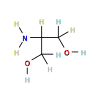

In [21]:
pybel.readstring('xyz', mol_string)

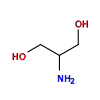

In [22]:
pybel.readstring('smi', smi)